# LLM-as-a-Judge: Automatische Qualitaetsbewertung

## Was ist LLM-as-a-Judge?

Wenn man Sprachmodelle trainiert, stellt sich die Frage: **Wie gut sind die generierten Texte?**

Es gibt drei Ansaetze:

| Ansatz | Vorteile | Nachteile |
|--------|----------|-----------|
| **Menschliche Bewertung** | Goldstandard, nuanciert | Langsam, teuer, nicht skalierbar |
| **Automatische Metriken** (BLEU, ROUGE) | Schnell, reproduzierbar | Korrelieren schlecht mit Qualitaet |
| **LLM-as-a-Judge** | Schnell, nuanciert, skalierbar | Abhaengig vom Judge-Modell, potenzielle Biases |

In diesem Notebook verwenden wir ein **grosses lokales LLM** (z.B. Qwen3 via Ollama/LM Studio),
um die Outputs unserer kleinen MiniGPT-Modelle zu bewerten.

### Bewertungskriterien

Jeder generierte Text wird auf drei Kriterien bewertet (je 1-5):
1. **Grammatik**: Korrektheit der Satzstruktur
2. **Kohaerenz**: Logischer Zusammenhang
3. **Relevanz**: Bezug zum Eingabe-Prompt

## Setup

**Voraussetzungen:**
- Trainierte Modelle (mindestens `python src/main.py` -> Option 2)
- LLM Judge-Service läuft (eine der folgenden Optionen):
  - **Ollama** lokal auf Port 11434
  - **LM Studio** lokal oder remote (z.B. `http://10.90.0.55:1234/v1`)
- `pip install openai`

**Konfiguration:** Im nächsten Abschnitt wählen Sie Ihren LLM Provider und konfigurieren die Verbindung.

## LLM Provider Konfiguration

Dieses Notebook kann mit verschiedenen LLM-Providern arbeiten:
- **Ollama** (lokaler Server)
- **LM Studio** (lokaler oder Remote-Server)

Die Verbindung wird über Umgebungsvariablen konfiguriert:
- `LLM_PROVIDER_URL`: API-Endpunkt (z.B. `http://10.90.0.55:1234/v1`)
- `LLM_MODEL`: Modellname (z.B. `qwen3:8b`)
- `LLM_API_KEY`: Optional - Authentifizierungs-Token falls erforderlich

### Konfigurationsbeispiele

**Beispiel 1: LM Studio Remote mit Authentication**
```python
os.environ['LLM_PROVIDER_URL'] = 'http://10.90.0.55:1234/v1'
os.environ['LLM_MODEL'] = 'qwen3:8b'
os.environ['LLM_API_KEY'] = 'sk-xxx...'  # Ihr Token
```

**Beispiel 2: LM Studio Lokal ohne Authentication**
```python
os.environ['LLM_PROVIDER_URL'] = 'http://localhost:1234/v1'
os.environ['LLM_MODEL'] = 'qwen3:8b'
os.environ.pop('LLM_API_KEY', None)  # API-Key entfernen
```

**Beispiel 3: Ollama Lokal**
```python
os.environ['LLM_PROVIDER_URL'] = 'http://localhost:11434/v1'
os.environ['LLM_MODEL'] = 'qwen3:8b'
```

**Hinweis:** Die API-Key-Authentifizierung ist optional. Viele lokale LM Studio-Installationen benötigen keinen API-Key.

In [5]:
import os

# =============================================================================
# KONFIGURATION: LM Studio / Ollama
# =============================================================================

# Option 1: LM Studio Remote (mit Authentication)
os.environ['LLM_PROVIDER_URL'] = 'http://10.90.0.55:1234/v1'
os.environ['LLM_MODEL'] = 'qwen3:8b'  # Ihr Modellname in LM Studio
#os.environ['LLM_API_KEY'] = 'your-token-here'  # Falls erforderlich

# Option 2: LM Studio Lokal (ohne Authentication)
# os.environ['LLM_PROVIDER_URL'] = 'http://localhost:1234/v1'
# os.environ['LLM_MODEL'] = 'qwen3:8b'

# Option 3: Ollama Lokal (Standard)
#os.environ['LLM_PROVIDER_URL'] = 'http://localhost:11434/v1'
#os.environ['LLM_MODEL'] = 'qwen3:8b'

# Optional: API-Key entfernen falls nicht benötigt
# os.environ.pop('LLM_API_KEY', None)

print(f"LLM Provider: {os.environ.get('LLM_PROVIDER_URL')}")
print(f"Modell: {os.environ.get('LLM_MODEL')}")
print(f"API Key gesetzt: {'Ja' if os.environ.get('LLM_API_KEY') else 'Nein'}")

LLM Provider: http://10.90.0.55:1234/v1
Modell: qwen3:8b
API Key gesetzt: Nein


### Verbindungstest

Testen Sie die Verbindung zum LLM Provider, bevor Sie fortfahren:

In [ ]:
import os
import sys
from pathlib import Path

# src-Verzeichnis zum Python-Path hinzufuegen (falls noch nicht geschehen)
src_path = Path("../src").resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from evaluation.llm_client import test_connection, get_model_name

# Verbindung testen
print("=" * 60)
print(f"Provider URL: {os.environ.get('LLM_PROVIDER_URL')}")
print(f"Modell:       {get_model_name()}")
print(f"API Key:      {'gesetzt' if os.environ.get('LLM_API_KEY') and os.environ.get('LLM_API_KEY') != 'not-needed' else 'nicht gesetzt'}")
print("=" * 60)

if test_connection():
    print("✓ Verbindung erfolgreich!")
else:
    print("✗ Verbindung fehlgeschlagen!")
    print("\nÜberprüfen Sie:")
    print("  1. Läuft der LLM-Server?")
    print("  2. Ist die URL korrekt?")
    print("  3. Ist das Modell geladen?")
    print("  4. Ist der API-Key korrekt (falls erforderlich)?")

ModuleNotFoundError: No module named 'evaluation'

In [1]:
import sys
from pathlib import Path

# src-Verzeichnis zum Python-Path hinzufuegen
src_path = Path("../src").resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import matplotlib.pyplot as plt
import numpy as np

# Stil setzen
plt.style.use('dark_background')
plt.rcParams.update({'axes.grid': True, 'grid.alpha': 0.3})

print(f"Python-Path: {src_path}")
print("Bibliotheken geladen!")

Python-Path: C:\SDK\lm-stack\machineLearning\languageModel\src
Bibliotheken geladen!


## Der Judge-Prompt

Das Herztueck von LLM-as-a-Judge ist der **System-Prompt**, der dem Judge-LLM erklaert,
wie es bewerten soll. Wichtig ist dabei:

- **Kontext geben**: Das Judge-LLM muss wissen, dass die Texte von einem winzigen Modell stammen
- **Klare Skala**: Jeder Score-Wert (1-5) wird explizit definiert
- **Strukturierte Ausgabe**: JSON-Format erzwingen fuer zuverlaessiges Parsing

In [2]:
from evaluation.judge import JUDGE_SYSTEM_PROMPT, JUDGE_USER_PROMPT_TEMPLATE

print("=== SYSTEM PROMPT ===")
print(JUDGE_SYSTEM_PROMPT)
print()
print("=== USER PROMPT TEMPLATE ===")
print(JUDGE_USER_PROMPT_TEMPLATE)

=== SYSTEM PROMPT ===
Du bist ein Bewertungs-Assistent fuer maschinell generierte deutsche Texte.

KONTEXT: Die Texte stammen von einem sehr kleinen Sprachmodell (MiniGPT, ~100k Parameter),
das auf einem winzigen deutschen Korpus trainiert wurde. Die Saetze sind kurz (5-10 Woerter).
Bewerte fair fuer dieses Niveau — perfekte Grammatik oder tiefe Semantik sind nicht zu erwarten.

Bewerte jeden Text auf drei Kriterien (je 1-5):

1. **grammatik_score** (1-5):
   1 = Voellig ungrammatisch, nur Wortsalat
   2 = Schwere Grammatikfehler, kaum lesbar
   3 = Erkennbare Struktur, aber deutliche Fehler
   4 = Weitgehend korrekte Grammatik, kleine Fehler
   5 = Grammatisch korrekt fuer dieses einfache Niveau

2. **kohaerenz_score** (1-5):
   1 = Kein Zusammenhang zwischen den Woertern
   2 = Einzelne Woerter passen, aber kein sinnvoller Satz
   3 = Ansatzweise sinnvoll, aber logische Brueche
   4 = Groesstenteils zusammenhaengend und sinnvoll
   5 = Klarer, zusammenhaengender Satz

3. **relevanz_s

## Modelle laden

Wir verwenden die gleichen Funktionen wie in der Inferenz, um alle
verfuegbaren Modelle (Original + Fine-Tuned) zu finden und zu laden.

In [3]:
from inference.inference_finetuned import discover_models, load_model_by_type, generate_text

base_dir = Path("../dist")
available = discover_models(base_dir)

print(f"Gefundene Modelle ({len(available)}):\n")
for name, info in available.items():
    print(f"  - {name:<20} {info['label']}")

# Alle Modelle laden
loaded_models = {}
for name, info in available.items():
    try:
        print(f"\nLade {info['label']}...")
        model, tokenizer = load_model_by_type(info, base_dir)
        loaded_models[name] = (model, tokenizer, info['label'])
    except Exception as e:
        print(f"  Fehler: {e}")

print(f"\n{len(loaded_models)} Modell(e) geladen.")

Gefundene Modelle (5):

  - original             Transformer (Basis-Training)
  - full_ft              Full Fine-Tuning
  - frozen               Layer Freezing
  - lora_adapter         LoRA (Adapter)
  - lora_merged          LoRA (Gemerged)

Lade Transformer (Basis-Training)...
🤖 MiniGPT erstellt:
   - Vokabular: 615 Tokens
   - Embedding: 64D
   - Attention Heads: 1
   - Transformer Layers: 2
   - Weight Tying: Ja
✅ Transformer-Modell geladen aus: ..\dist\transformer_model

Lade Full Fine-Tuning...
🤖 MiniGPT erstellt:
   - Vokabular: 90 Tokens
   - Embedding: 64D
   - Attention Heads: 1
   - Transformer Layers: 2
   - Weight Tying: Nein
✅ Transformer-Modell geladen aus: ..\dist\finetuning_results\full_finetuned

Lade Layer Freezing...
🤖 MiniGPT erstellt:
   - Vokabular: 90 Tokens
   - Embedding: 64D
   - Attention Heads: 1
   - Transformer Layers: 2
   - Weight Tying: Nein
✅ Transformer-Modell geladen aus: ..\dist\finetuning_results\layer_frozen

Lade LoRA (Adapter)...
🤖 MiniGPT erste

## Einzelbeispiel: Ein Prompt bewerten

Bevor wir alle Modelle systematisch bewerten, schauen wir uns
einen einzelnen Durchlauf an: **Prompt -> Generierung -> Judge -> Score**

In [4]:
from evaluation.llm_client import test_connection, get_model_name
from evaluation.judge import evaluate_single_output

# LLM-Verbindung pruefen
print(f"Judge-Modell: {get_model_name()}")
print(f"Verbindung: {'OK' if test_connection() else 'FEHLGESCHLAGEN'}")

# Erstes Modell nehmen
first_key = list(loaded_models.keys())[0]
model, tokenizer, label = loaded_models[first_key]

# Text generieren
test_prompt = "die katze"
generated = generate_text(model, tokenizer, test_prompt, max_length=8, temperature=0.8)

print(f"\nModell:     {label}")
print(f"Prompt:     '{test_prompt}'")
print(f"Generiert:  '{generated}'")

# Judge bewerten lassen
score = evaluate_single_output(test_prompt, generated)

if score:
    print(f"\n--- Bewertung ---")
    print(f"Grammatik:  {score.grammatik_score}/5")
    print(f"Kohaerenz:  {score.kohaerenz_score}/5")
    print(f"Relevanz:   {score.relevanz_score}/5")
    print(f"Gesamt:     {score.gesamt_score}/5")
    print(f"Begruendung: {score.begruendung}")
else:
    print("\nBewertung fehlgeschlagen!")

Judge-Modell: qwen3:8b
   [X] LLM connection failed: Error code: 400 - {'error': {'message': 'Invalid model identifier "qwen3:8b". Please specify a valid downloaded model (e.g., qwen/qwen3-8b@q4_k_m, qwen/qwen3-8b, qwen3-8b).', 'type': 'invalid_request_error', 'param': 'model', 'code': 'model_not_found'}}
Verbindung: FEHLGESCHLAGEN

Modell:     Transformer (Basis-Training)
Prompt:     'die katze'
Generiert:  'die katze schläft teller den käse <EOS>'
   [!] First attempt failed: Error code: 400 - {'error': {'message': 'Invalid model identifier "qwen3:8b". Please specify a valid downloaded model (e.g., qwen/qwen3-8b@q4_k_m, qwen/qwen3-8b, qwen3-8b).', 'type': 'invalid_request_error', 'param': 'model', 'code': 'model_not_found'}}
   [X] Evaluation failed after retry: Error code: 400 - {'error': {'message': 'Invalid model identifier "qwen3:8b". Please specify a valid downloaded model (e.g., qwen/qwen3-8b@q4_k_m, qwen/qwen3-8b, qwen3-8b).', 'type': 'invalid_request_error', 'param': 'model',

## Systematische Bewertung: Alle Modelle x Alle Prompts

Jetzt bewerten wir **jedes Modell** auf **jedem Prompt** und sammeln die Ergebnisse.

In [5]:
from evaluation.judge_config import (
    DEFAULT_TEST_PROMPTS,
    GENERATION_TEMPERATURE,
    GENERATION_MAX_LENGTH,
    GeneratedOutput,
    ModelEvaluationResult,
)

prompts = DEFAULT_TEST_PROMPTS
print(f"Prompts: {prompts}")
print(f"Temperature: {GENERATION_TEMPERATURE}")
print(f"Max. Laenge: {GENERATION_MAX_LENGTH}")
print(f"Modelle: {len(loaded_models)}")
print(f"Gesamt-Bewertungen: {len(prompts) * len(loaded_models)}")
print()

all_results = []

for model_key, (model, tokenizer, label) in loaded_models.items():
    model_result = ModelEvaluationResult(model_name=model_key, label=label)
    print(f"\n=== {label} ===")
    
    for prompt in prompts:
        generated = generate_text(
            model, tokenizer, prompt,
            max_length=GENERATION_MAX_LENGTH,
            temperature=GENERATION_TEMPERATURE,
        )
        
        score = evaluate_single_output(prompt, generated)
        output = GeneratedOutput(
            model_name=model_key,
            prompt=prompt,
            generated_text=generated,
            score=score,
        )
        model_result.outputs.append(output)
        
        score_str = f"G:{score.grammatik_score} K:{score.kohaerenz_score} R:{score.relevanz_score} = {score.gesamt_score:.2f}" if score else "FEHLER"
        print(f"  '{prompt}' -> '{generated}' [{score_str}]")
    
    all_results.append(model_result)

print("\nBewertung abgeschlossen!")

Prompts: ['die katze', 'der hund', 'das kind spielt', 'die sonne scheint', 'der mann liest']
Temperature: 0.5
Max. Laenge: 12
Modelle: 5
Gesamt-Bewertungen: 25


=== Transformer (Basis-Training) ===
   [!] First attempt failed: Error code: 400 - {'error': {'message': 'Invalid model identifier "qwen3:8b". Please specify a valid downloaded model (e.g., qwen/qwen3-8b@q4_k_m, qwen/qwen3-8b, qwen3-8b).', 'type': 'invalid_request_error', 'param': 'model', 'code': 'model_not_found'}}
   [X] Evaluation failed after retry: Error code: 400 - {'error': {'message': 'Invalid model identifier "qwen3:8b". Please specify a valid downloaded model (e.g., qwen/qwen3-8b@q4_k_m, qwen/qwen3-8b, qwen3-8b).', 'type': 'invalid_request_error', 'param': 'model', 'code': 'model_not_found'}}
  'die katze' -> 'die katze springt über das die hund <EOS>' [FEHLER]
   [!] First attempt failed: Error code: 400 - {'error': {'message': 'Invalid model identifier "qwen3:8b". Please specify a valid downloaded model (e.g., qw

## Ergebnis-Tabelle

In [6]:
# Ranking
ranked = sorted(all_results, key=lambda r: r.avg_gesamt, reverse=True)

print(f"{'Rang':<6} {'Modell':<28} {'Gesamt':>8} {'Gram.':>8} {'Koh.':>8} {'Rel.':>8}")
print("-" * 72)

for i, r in enumerate(ranked, 1):
    print(
        f"{i:<6} {r.label:<28} {r.avg_gesamt:>8.2f} "
        f"{r.avg_grammatik:>8.2f} {r.avg_kohaerenz:>8.2f} {r.avg_relevanz:>8.2f}"
    )

Rang   Modell                         Gesamt    Gram.     Koh.     Rel.
------------------------------------------------------------------------
1      Transformer (Basis-Training)     0.00     0.00     0.00     0.00
2      Full Fine-Tuning                 0.00     0.00     0.00     0.00
3      Layer Freezing                   0.00     0.00     0.00     0.00
4      LoRA (Adapter)                   0.00     0.00     0.00     0.00
5      LoRA (Gemerged)                  0.00     0.00     0.00     0.00


## Visualisierung: Radar-Chart

Ein Radar-Chart zeigt die drei Kriterien pro Modell auf einen Blick.
Groessere Flaeche = besseres Modell.

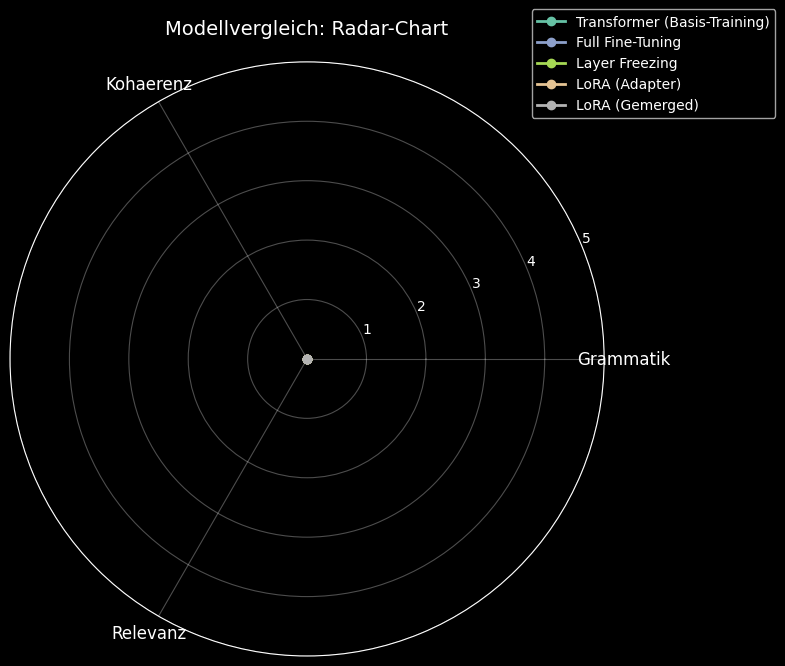

In [7]:
def plot_radar_chart(results):
    """Radar-Chart: 3 Kriterien pro Modell."""
    categories = ['Grammatik', 'Kohaerenz', 'Relevanz']
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Schliessen

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    colors = plt.cm.Set2(np.linspace(0, 1, len(results)))

    for i, r in enumerate(results):
        values = [r.avg_grammatik, r.avg_kohaerenz, r.avg_relevanz]
        values += values[:1]  # Schliessen
        ax.plot(angles, values, 'o-', linewidth=2, label=r.label, color=colors[i])
        ax.fill(angles, values, alpha=0.15, color=colors[i])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_ylim(0, 5)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_title('Modellvergleich: Radar-Chart', fontsize=14, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

plot_radar_chart(all_results)

## Visualisierung: Grouped Bar Chart

Direkter Vergleich der Scores pro Kriterium.

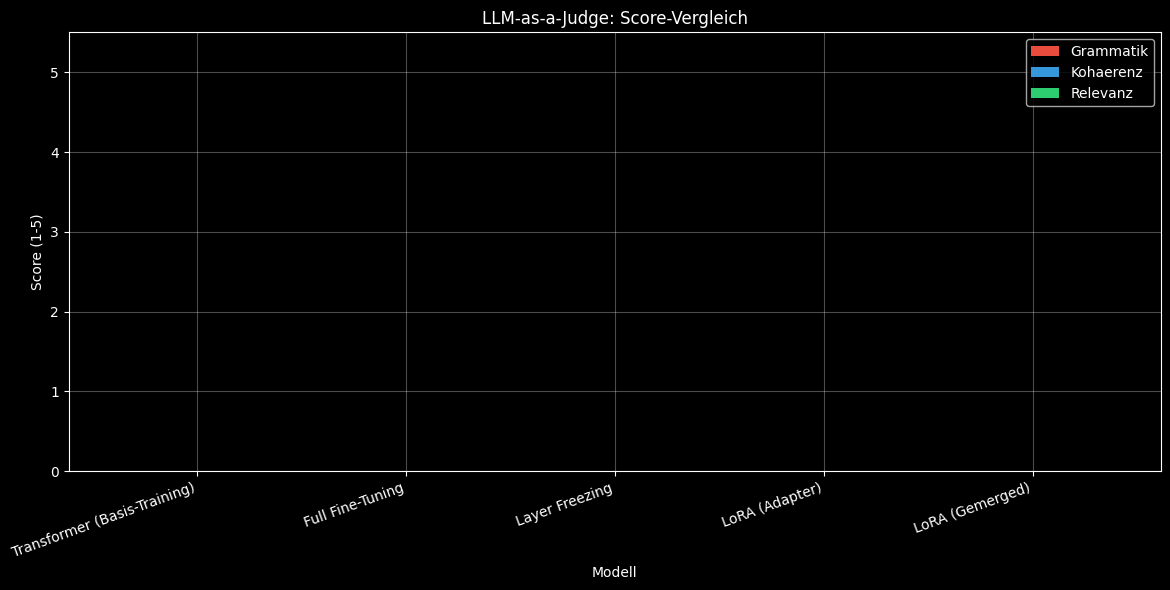

In [8]:
def plot_grouped_bar(results):
    """Grouped Bar Chart: Kriterien nebeneinander pro Modell."""
    labels = [r.label for r in results]
    grammatik = [r.avg_grammatik for r in results]
    kohaerenz = [r.avg_kohaerenz for r in results]
    relevanz = [r.avg_relevanz for r in results]

    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, grammatik, width, label='Grammatik', color='#e74c3c')
    ax.bar(x, kohaerenz, width, label='Kohaerenz', color='#3498db')
    ax.bar(x + width, relevanz, width, label='Relevanz', color='#2ecc71')

    ax.set_xlabel('Modell')
    ax.set_ylabel('Score (1-5)')
    ax.set_title('LLM-as-a-Judge: Score-Vergleich')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=20, ha='right')
    ax.set_ylim(0, 5.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_grouped_bar(all_results)

## Visualisierung: Heatmap (Prompt x Modell)

Zeigt den Gesamtscore fuer jede Kombination aus Prompt und Modell.

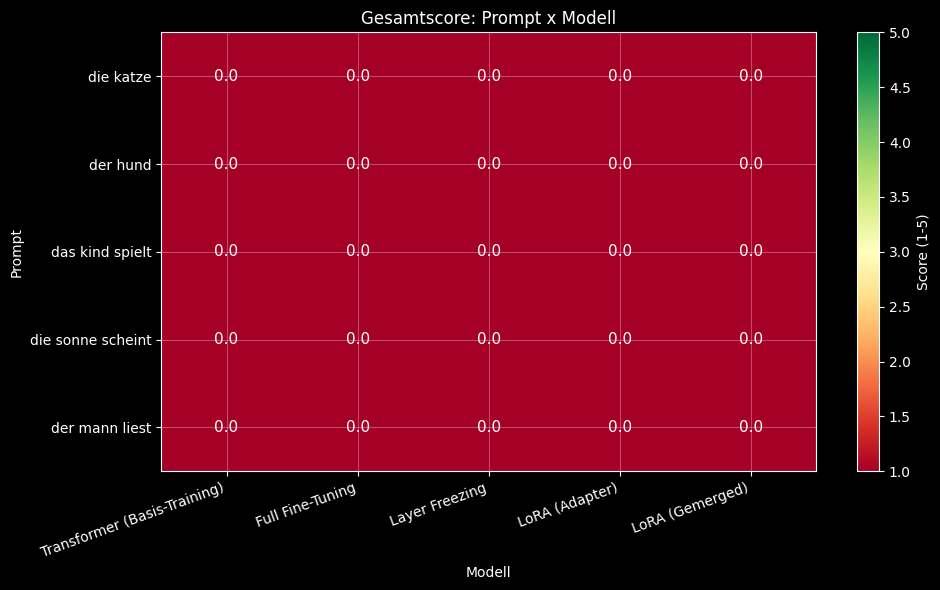

In [9]:
def plot_heatmap(results, prompts):
    """Heatmap: Gesamtscore pro Prompt x Modell."""
    model_labels = [r.label for r in results]
    
    # Matrix aufbauen
    matrix = np.zeros((len(prompts), len(results)))
    for j, r in enumerate(results):
        for i, o in enumerate(r.outputs):
            if o.score:
                matrix[i, j] = o.score.gesamt_score
    
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(matrix, cmap='RdYlGn', vmin=1, vmax=5, aspect='auto')
    
    ax.set_xticks(range(len(model_labels)))
    ax.set_xticklabels(model_labels, rotation=20, ha='right')
    ax.set_yticks(range(len(prompts)))
    ax.set_yticklabels(prompts)
    ax.set_xlabel('Modell')
    ax.set_ylabel('Prompt')
    ax.set_title('Gesamtscore: Prompt x Modell')
    
    # Werte in Zellen schreiben
    for i in range(len(prompts)):
        for j in range(len(results)):
            val = matrix[i, j]
            color = 'black' if val > 3 else 'white'
            ax.text(j, i, f'{val:.1f}', ha='center', va='center', color=color, fontsize=11)
    
    plt.colorbar(im, ax=ax, label='Score (1-5)')
    plt.tight_layout()
    plt.show()

plot_heatmap(all_results, DEFAULT_TEST_PROMPTS)

## Bias-Analyse: Grenzen von LLM-as-a-Judge

LLM-as-a-Judge ist maechtig, aber nicht perfekt. Bekannte Probleme:

### 1. Laengenbias (Length Bias)
Grosse LLMs bevorzugen oft **laengere Antworten**, auch wenn kuerzere praeziser waeren.
Bei unseren MiniGPT-Modellen ist das weniger relevant (alle generieren ~5-10 Woerter),
aber bei groesseren Modellen ein ernstes Problem.

### 2. Selbstbevorzugung (Self-Enhancement Bias)
Ein LLM bewertet Texte, die seinem eigenen Stil aehneln, tendenziell besser.
Da unsere MiniGPT-Texte sehr anders sind als typische LLM-Outputs,
ist dieser Bias hier weniger ausgepraegt.

### 3. Positions-Bias
Wenn mehrere Texte verglichen werden, bevorzugen LLMs oft den **ersten** oder **letzten** Text.
Wir vermeiden das, indem wir jeden Text **einzeln** bewerten.

### 4. Kalibrierungsprobleme
Verschiedene Judge-Modelle koennen stark unterschiedliche Scores geben.
Ein Qwen3:8b bewertet moeglicherweise strenger als ein GPT-4.
Deshalb sind **relative Rankings** zuverlaessiger als absolute Scores.

### Gegenmassnahmen

| Problem | Gegenmassnahme |
|---------|----------------|
| Laengenbias | Einzelbewertung statt Vergleich |
| Selbstbevorzugung | Lokales Open-Source-Modell als Judge |
| Kalibrierung | Kalibrierter Prompt mit expliziter Skala |
| Rauschen | Mehrere Durchlaeufe, Mittelwert bilden |

## Report generieren

In [10]:
from evaluation.evaluation_report import generate_evaluation_report

report_dir = Path("../dist/evaluation_results")
report = generate_evaluation_report(all_results, report_dir)

print("Report gespeichert!")
print(f"Pfad: {report_dir / 'EVALUATION_REPORT.md'}")

   Report gespeichert: ..\dist\evaluation_results\EVALUATION_REPORT.md
Report gespeichert!
Pfad: ..\dist\evaluation_results\EVALUATION_REPORT.md


## Zusammenfassung

### Was wir gelernt haben

- **LLM-as-a-Judge** ermoeglicht automatisierte, nuancierte Textbewertung
- Ein grosses LLM (Judge) bewertet die Outputs kleiner Modelle auf definierten Kriterien
- Strukturierte Prompts mit JSON-Ausgabe machen die Ergebnisse maschinell auswertbar
- Verschiedene Fine-Tuning-Methoden fuehren zu unterschiedlicher Textqualitaet

### Wann LLM-as-a-Judge nutzen?

| Situation | Empfehlung |
|-----------|------------|
| Schnelle Iteration waehrend der Entwicklung | LLM-as-a-Judge |
| Vergleich vieler Modellvarianten | LLM-as-a-Judge |
| Finale Qualitaetssicherung | Menschliche Bewertung |
| Reproduzierbare Benchmark-Scores | Automatische Metriken (BLEU, etc.) |
| Sicherheits-/Bias-Pruefung | Kombination aus LLM-Judge + Mensch |

### Limitationen

- Ergebnisse haengen stark vom Judge-Modell ab
- Absolute Scores sind weniger aussagekraeftig als relative Rankings
- Fuer produktive Systeme sollte immer auch menschliche Evaluation stattfinden